In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                                ])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]


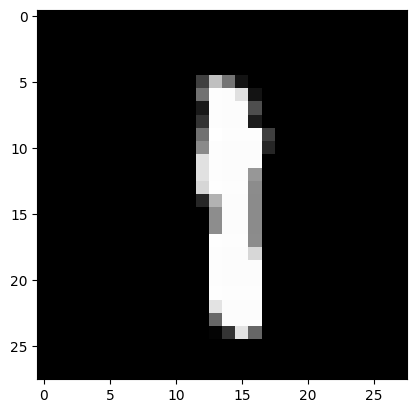

In [7]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0].numpy().squeeze()

plt.imshow(image, cmap='gray')




In [8]:
def aplanar_image(x):
  return x.view(x.size(0), -1)
# Mi version:
# def aplanar_imagen(x):
#   return x.view(x.size(0, -1))





import torch.nn as nn
import torch.nn.functional as F
def aplanar_imagen(x):
  return x.view(x.size(0, -1))
class MNISTNet(nn.Module):
  def __init__(self):
    super(MNISTNet, self).__init__()

    # Usar la calculadora dada en el campus
    self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # (N, 16, 28, 28) -> (N, 16, 14, 14)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)

    # El pooling divide a la mitad el tamaño de la entrada
    self.fc1 = nn.Linear(32*7*7, 120)
    self.fc2 = nn.Linear(120, 10)

  def forward(self, x):
    # x = self.conv1(x)
    # x = F.relu(x)
    # x = self.pool(x)
    x = self.pool(F.relu(self.conv1(x))) # (N, 1, 28, 28) -> (N, 16, 14, 14)
    x = self.pool(F.relu(self.conv2(x))) # (N, 16, 14, 14) -> (N, 32, 7, 7)

    x = x.view(-1, 32*7*7) # Aplanar imagen

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [9]:
# Instanciamos la red
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MNISTNet().to(device)

# Definición de la función de pérdidoa y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [10]:
# Entrenamiento de la red

num_epochs = 10

for epoch in range(num_epochs):
  epoch_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    # Forward: Calculamos las salidas
    output = net(images)

    # Calculamos la pérdida
    loss = loss_fn(output, labels)

    # Retropropagación - cálculo del gradiente
    loss.backward()

    # Actualizar los pesos/parámetros
    optimizer.step()

    # Limpiar los gradientes
    optimizer.zero_grad()

    epoch_loss += loss.item()

  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')



Epoch 1/10, Loss: 0.7771559753286432
Epoch 2/10, Loss: 0.16993694019907002
Epoch 3/10, Loss: 0.11362875552415085
Epoch 4/10, Loss: 0.08962874472546362
Epoch 5/10, Loss: 0.0752461287580224
Epoch 6/10, Loss: 0.06567147471306564
Epoch 7/10, Loss: 0.05911198018296465
Epoch 8/10, Loss: 0.05375151057689905
Epoch 9/10, Loss: 0.0490107016766003
Epoch 10/10, Loss: 0.0456809761266518


In [11]:
# Evaluación del modelo
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    output = net(images)
    _, predicted = torch.max(output.data, 1)

    correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 98.55%
